# Demo: Kernel Ridge Regression + Linear Transfer-learning + Gaussian process regression

## Motivation of practical multi-fidelity Bayesian machine learning
MF data arises naturally in most engineering applications. High-fidelity data is often associated with costly and time-consuming experiments, or with accurate yet computationally expensive simulations. In contrast, LF data is usually obtained by efficient strategies (experimental , analytical  , or computational  at the expense of accuracy. Therefore, LF data is typically acquired faster, often by several orders of magnitude. Using both datasets can be advantageous to train better models as long as the loss in fidelity is compensated by the presence of more low-fidelity data.

<center><img src="figures/mf_motivation.png" width="30%"> </center>
<center> Figure: Multi-fidelity data from engineering analysis </center>
<br>

## Gaussian process regression  

- **Uncertainty quantification**
- *Single-fidelity* 
- *Scalability* 



## Unified multi-fidelity framwork 
$$f^h(\mathbf{x}) = g\left(f^l(\mathbf{x}), \mathbf{x} \right) + r(\mathbf{x})$$


In the data-scarce literature, MF models use GPRs for both $f^l(\mathbf{x})$ and $r(\mathbf{x})$ and consider a linear transfer-learning model $g(\mathbf{x}):= g(f^l(\mathbf{x})) = f^l(\mathbf{x}) \rho$, such that:

$$
     f^h(\mathbf{x})= f^l(\mathbf{x})\rho + r(\mathbf{x})
$$
 
where $\rho$ is a single hyperparameter that transforms the LF model $f^l(\mathbf{x})$ to the HF responses.

Other investigations focus on using a transfer-learning model of higher complexity, for example, Bayesian models, while setting $r(\mathbf{x}):= 0$, leading to:

$$
    f^h(\mathbf{x}) = g\left( f^l(\mathbf{x}), \mathbf{x}\right)
$$


## Practical multi-fidelity Bayesian Machine learning
- **Uncertainty quantification**
- **Unified framework:** 
    Deterministic LF + transfer-learning + Bayesian residual  
- **Data-scarce + Data-rich**

$$
\begin{align}
 f^h(\mathbf{x})  &=   g\left(f^l(\mathbf{x})\right) + r(\mathbf{x}) \\  
    &= \bm{m}(\mathbf{x})^T\bm{\rho}+  r(\mathbf{x}) \\ 
     &= \rho_0 + f^l(\mathbf{x})\rho_1 + f^l(\mathbf{x})^2\rho_2+ \ldots + f^l(\mathbf{x})^{M-1}\rho_{M-1}+r(\mathbf{x})
     \end{align}
     $$

<center><img src="figures/mf_bml_framework.png" width="50%"> </center>
<center>Illustration of how the practical MF-BML evolves from GPR. (a) GPR with explicit basis function, in which a first linear regression is executed based on the basis function and the remaining is assumed to be a zero mean GPR for characterizing the residual. (b) the practical MF-BML follows the same concept by utilizing the LF surrogate as the basis. A linear transfer-learning function on LF model adjusts the prediction for the HF, and facilitates the determination of the residual by a Bayesian model with a simple prior.  </center>
<br>

**Candidates for the LF and HF modelss**
<div align="center">

| **LF Surrogates**                                     | **HF Surrogates**                                 |
|-------------------------------------------------------|---------------------------------------------------|
| Linear regression (LR)                                | Gaussian process regression (GPR)                 |
| Kernel ridge regression (KRR)                         | Polynomial chaos expansion (PCE)                  |
| Deep neural network (DNN)                             | Bayesian neural network (BNN)                     |
| Support Vector Regression (SVR)                       | ...                                               |
| Gaussian process regression (GPR)                   |                                                   |
| Polynomial chaos expansion (PCE)                    |                                                   |
| ...                                                   |                                                   |




In [1]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt

from mfbml.methods.krr_lr_gpr import KernelRidgeLinearGaussianProcess as KRRLRGPR
from mfbml.methods.kernel_ridge_regression import KernelRidgeRegression as RBFKernelRegression
from mfbml.problems.illustrative_problems import mf_Forrester

# import single fidelity Gaussian process model from mfpml 
from mfpml.models.gaussian_process import GaussianProcessRegression


In [2]:
# fix the random seed for reproducibility
seed_number = 1999
np.random.seed(seed_number)

## KRR-LR-GPR for noisy data

- function： Forrester function 
- hf samples: 7 
- lf samples: 200


In [3]:
func = mf_Forrester()

# get the samples use np.linspace
sample_hx = np.linspace(0, 1, 7).reshape(-1, 1)
sample_lx = np.linspace(0, 1, 200).reshape(-1, 1)
sample_x = [sample_hx, sample_lx]

# get the high and low fidelity responses
sample_y = [func.hf(sample_hx), func.lf_2(sample_lx)]

# add noise to the samples
sample_y[0] += np.random.normal(0, 0.3, sample_y[0].shape)
sample_y[1] += np.random.normal(0, 0.3, sample_y[1].shape)
# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf_2(test_x)

# test data noise)
test_hy_noise = test_hy + np.random.normal(0, 0.3, test_hy.shape)
test_ly_noise = test_hy + np.random.normal(0, 0.3, test_ly.shape)

In [4]:
model_noisy = KRRLRGPR(
    design_space=func.design_space,
    optimizer_restart=10,
    seed=seed_number,
    lf_poly_order="linear_without_const",  # linear, quadratic, cubic, linear_without_bias， ordinary
)
# update the info of low-fidelity model (optional)
model_noisy.lf_model = RBFKernelRegression(design_space=func.design_space,
                                           optimizer_restart=10,
                                           noise_data=True,
                                           seed=seed_number)
model_noisy.train(X=sample_x, Y=sample_y)
pred_y, pred_std = model_noisy.predict(X=test_x, return_std=True)
# get prediction of low fidelity
pred_ly = model_noisy.predict_lf(X=test_x)


print("lf time", model_noisy.lf_training_time)
print("hf time", model_noisy.hf_training_time)
print("noise", model_noisy.noise)
print("rho", model_noisy.beta)

lf time 10.354272603988647
hf time 0.17156314849853516
noise 0.5053295309231746
rho [[1.87768557]]


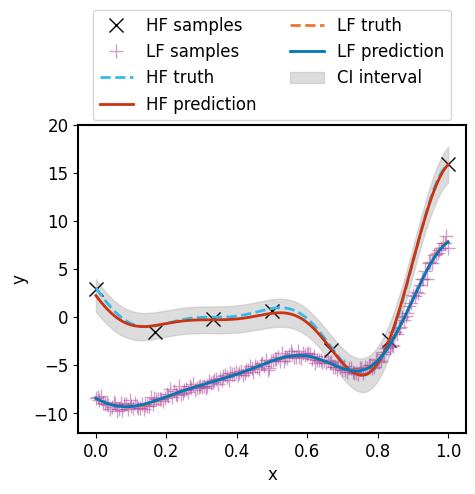

In [5]:
# visualize the results
font_size = 12
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax.plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    alpha=0.5,
    label="LF samples",
)
ax.plot(test_x, test_hy, "--", color="#33BBEE",
        linewidth=2, label="HF truth")
ax.plot(test_x, pred_y, "-", color="#CC3311",
        linewidth=2, label="HF prediction")
ax.plot(test_x, test_ly, "--", color="#EE7733",
        linewidth=2, label="LF truth")
ax.plot(test_x, pred_ly, "-", color="#0077BB",
        linewidth=2, label="LF prediction")
ax.fill_between(
    test_x.flatten(),
    (pred_y - 2 * pred_std).flatten(),
    (pred_y + 2 * pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax.set_ylabel("y", fontsize=font_size)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylim(-12, 20)
ax.legend()

# ax.text(
#     0.5,
#     17.0,
#     r"$\hat \rho_0$ = {:.2f}  $\hat \rho_1$ = {:.2f}".format(
#         model_noisy.beta[0, 0], model_noisy.beta[1, 0]
#     ),
#     fontsize=font_size,
#     ha="center",
#     va="center",
#     backgroundcolor="white",
# )

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=font_size)
# set the line width of the axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

plt.show()

### KRR-LR-GPR for noiseless case
- function: Forrester
- hf samples: 4 
- lf samples: 11

In [6]:
# get the samples use np.linspace
sample_hx_noiseless = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))
sample_lx_noiseless = np.linspace(0, 1, 11, endpoint=True).reshape((-1, 1))
sample_x_noiseless = [sample_hx_noiseless, sample_lx_noiseless]

# get the high and low fidelity responses
sample_y_noiseless = [func.hf(sample_hx_noiseless),
                      func.lf_2(sample_lx_noiseless)]

# generate test samples
test_x_noiseless = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy_noiseless = func.hf(test_x_noiseless)
test_ly_noiseless = func.lf_2(test_x_noiseless)

In [7]:
# model without noise
model_noiseless = KRRLRGPR(
    design_space=func.design_space,
    optimizer_restart=10,
    seed=seed_number,
    noise_prior=0.0,
)
model_noiseless.lf_model = RBFKernelRegression(design_space=func.design_space,
                                               optimizer_restart=10,
                                               noise_data=False,
                                               seed=seed_number)
model_noiseless.train(X=sample_x_noiseless, Y=sample_y_noiseless)
pred_y_noiseless, pred_std_noiseless = model_noiseless.predict(
    X=test_x_noiseless, return_std=True)
# get prediction of low fidelity
pred_ly_noiseless = model_noiseless.predict_lf(X=test_x_noiseless)

# get the training time
lf_training_time_noiseless = model_noiseless.lf_training_time
hf_training_time_noiseless = model_noiseless.hf_training_time

# print the training time
print("lf time", lf_training_time_noiseless)
print("hf time", hf_training_time_noiseless)
print("noise", model_noiseless.noise)

lf time 0.3075833320617676
hf time 0.018696069717407227
noise 0.0


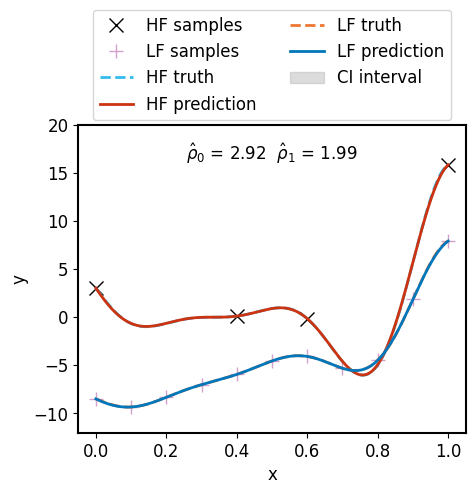

In [8]:
# plot the results
font_size = 12
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    sample_x_noiseless[0],
    sample_y_noiseless[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax.plot(
    sample_x_noiseless[1],
    sample_y_noiseless[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    alpha=0.5,
    label="LF samples",
)
ax.plot(test_x_noiseless, test_hy_noiseless, "--", color="#33BBEE",
        linewidth=2, label="HF truth")
ax.plot(test_x_noiseless, pred_y_noiseless, "-", color="#CC3311",
        linewidth=2, label="HF prediction")
ax.plot(test_x_noiseless, test_ly_noiseless, "--", color="#EE7733",
        linewidth=2, label="LF truth")
ax.plot(test_x_noiseless, pred_ly_noiseless, "-", color="#0077BB",
        linewidth=2, label="LF prediction")
ax.fill_between(
    test_x_noiseless.flatten(),
    (pred_y_noiseless - 2 * pred_std_noiseless).flatten(),
    (pred_y_noiseless + 2 * pred_std_noiseless).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax.set_ylabel("y", fontsize=font_size)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylim(-12, 20)
ax.legend()

ax.text(
    0.5,
    17.0,
    r"$\hat \rho_0$ = {:.2f}  $\hat \rho_1$ = {:.2f}".format(
        model_noiseless.beta[0, 0], model_noiseless.beta[1, 0]
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=font_size)
# set the line width of the axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

plt.show()

## What if we have a lf model already trained or a theorectical model? 

> This is still under developing, but based on this version. I can also easily do it. 







In [9]:
# what we need is a model class with the following features

class SelfDfineLFmodel:

    def train(self, X: np.ndarray, Y: np.ndarray) -> None:
        
        # this function use to train the lf model, but if it is not needed, we can pass

        pass

    def predict(self, X: np.ndarray) -> np.ndarray:
        # take the input and return the prediction of the low fidelity model
        # it is noted that the X and Y should be the orginal scale
        
        pass


### Case 1： Replace KRR model with another Gaussian process regression model 


In [10]:
gpr_lr_gpr = KRRLRGPR(
    design_space=func.design_space,
    optimizer_restart=10,
    seed=seed_number,
    noise_prior=0.0,
)
# change the lf model to the new model
gpr_lr_gpr.lf_model = GaussianProcessRegression(design_space=func.design_space,
                                                optimizer_restart=10,
                                                noise_prior=0,)
# train the gpr_lr_gpr model 
gpr_lr_gpr.train(X=sample_x_noiseless, Y=sample_y_noiseless)

# print some information
print("lf time", gpr_lr_gpr.lf_training_time)
print("hf time", gpr_lr_gpr.hf_training_time)
print("noise", gpr_lr_gpr.noise)

lf time 0.07256317138671875
hf time 0.018837690353393555
noise 0.0


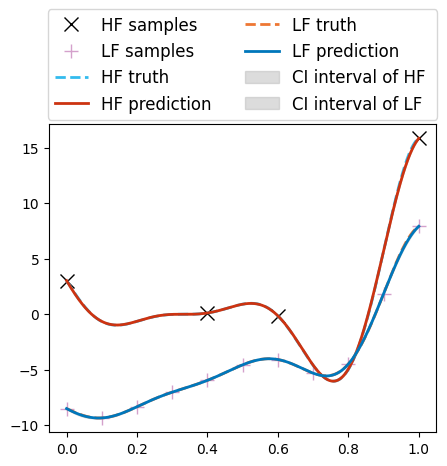

In [11]:

# get the prediction
pred_y_gpr_lr_gpr, pred_std_gpr_lr_gpr = gpr_lr_gpr.predict(
    X=test_x_noiseless, return_std=True)

# get prediction of low fidelity
# pred_ly_gpr_lr_gpr = gpr_lr_gpr.predict_lf(X=test_x_noiseless)
pred_ly_gpr_lr_gpr, pred_ly_std_gpr_lr_gpr = gpr_lr_gpr.lf_model.predict(X=test_x_noiseless, return_std=True)

# plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    sample_x_noiseless[0],
    sample_y_noiseless[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax.plot(
    sample_x_noiseless[1],
    sample_y_noiseless[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    alpha=0.5,
    label="LF samples",
)
ax.plot(test_x_noiseless, test_hy_noiseless, "--", color="#33BBEE",
        linewidth=2, label="HF truth")
ax.plot(test_x_noiseless, pred_y_gpr_lr_gpr, "-", color="#CC3311",
        linewidth=2, label="HF prediction")
ax.plot(test_x_noiseless, test_ly_noiseless, "--", color="#EE7733",
        linewidth=2, label="LF truth")
ax.plot(test_x_noiseless, pred_ly_gpr_lr_gpr, "-", color="#0077BB",
        linewidth=2, label="LF prediction")
ax.fill_between(
    test_x_noiseless.flatten(),
    (pred_y_gpr_lr_gpr - 2 * pred_std_gpr_lr_gpr).flatten(),
    (pred_y_gpr_lr_gpr + 2 * pred_std_gpr_lr_gpr).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval of HF ",
)
ax.fill_between(
    test_x_noiseless.flatten(),
    (pred_ly_gpr_lr_gpr - 2 * pred_ly_std_gpr_lr_gpr).flatten(),
    (pred_ly_gpr_lr_gpr + 2 * pred_ly_std_gpr_lr_gpr).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval of LF",
)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=12)
plt.show()  


### Case 2： Replace KRR model with another Gaussian process regression model 

In [12]:
# for example 
class TheorecticalLFmodel:

    def train(self, X: np.ndarray, Y: np.ndarray) -> None:
        
        # this function use to train the lf model, but if it is not needed, we can pass

        pass

    def predict(self, X: np.ndarray) -> np.ndarray:
        # take the input and return the prediction of the low fidelity model
        # it is noted that the X and Y should be the orginal scale

        obj = X**2

        return obj

In [13]:
model_with_theoretical_lf = KRRLRGPR(
    design_space=func.design_space,
    optimizer_restart=10,
    seed=seed_number,
    noise_prior=0.0,
)

model_with_theoretical_lf.lf_model = TheorecticalLFmodel()

In [16]:
model_with_theoretical_lf.train(X = sample_x_noiseless,
                                    Y = sample_y_noiseless)

# show the training time
print("lf time", model_with_theoretical_lf.lf_training_time)
print("hf time", model_with_theoretical_lf.hf_training_time)
print("noise", model_with_theoretical_lf.noise)
print("rho", model_with_theoretical_lf.beta)

lf time 0.0
hf time 0.02621936798095703
noise 0.0
rho [[ 9.58924547]
 [14.36134863]]


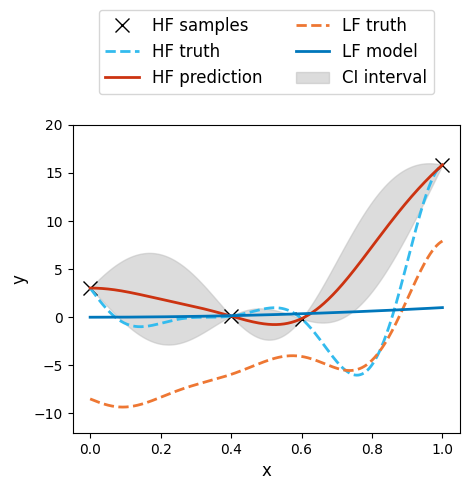

In [21]:
# get the prediction of this model 
pred_y_theoretical_lf, pred_std_theoretical_lf = model_with_theoretical_lf.predict(
    X=test_x_noiseless, return_std=True)
# get prediction of low fidelity
pred_ly_theoretical_lf = model_with_theoretical_lf.predict_lf(X=test_x_noiseless)

# plot the results
font_size = 12
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    sample_x_noiseless[0],
    sample_y_noiseless[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)

ax.plot(test_x_noiseless, test_hy_noiseless, "--", color="#33BBEE",
        linewidth=2, label="HF truth")
ax.plot(test_x_noiseless, pred_y_theoretical_lf, "-", color="#CC3311",
        linewidth=2, label="HF prediction")
ax.plot(test_x_noiseless, test_ly_noiseless, "--", color="#EE7733",
        linewidth=2, label="LF truth")
ax.plot(test_x_noiseless, pred_ly_theoretical_lf, "-", color="#0077BB",
        linewidth=2, label="LF model")
ax.fill_between(
    test_x_noiseless.flatten(),
    (pred_y_theoretical_lf - 2 * pred_std_theoretical_lf).flatten(),
    (pred_y_theoretical_lf + 2 * pred_std_theoretical_lf).flatten(),
    edgecolor=None,
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax.set_ylabel("y", fontsize=font_size)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylim(-12, 20)
ax.legend()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=12)
plt.show()


### Single fidelity Gaussian process regression model
- In case you wanna to know the performance of a Gaussian process regression model, we provide the corresponding code and you feel free to explore it 

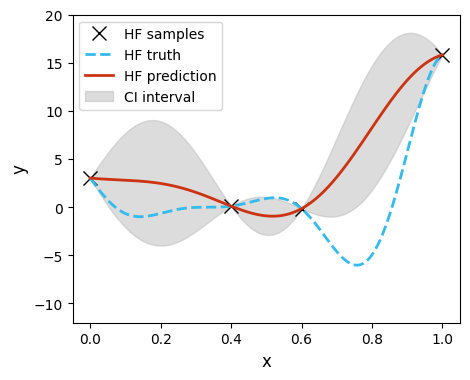

In [23]:
sf_gpr_noiseless = GaussianProcessRegression(design_space=func.design_space,
                                                optimizer_restart=10,
                                                noise_prior=0.0)
# train the gaussian process model
sf_gpr_noiseless.train(X=sample_hx_noiseless, Y=mf_Forrester().hf(sample_hx_noiseless))

# get the prediction
pred_y_sf_gpr_noiseless, pred_std_sf_gpr_noiseless = sf_gpr_noiseless.predict(
    X=test_x_noiseless, return_std=True)

# plot the results
font_size = 12
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    sample_x_noiseless[0],
    mf_Forrester().hf(sample_hx_noiseless),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)

ax.plot(test_x_noiseless, test_hy_noiseless, "--", color="#33BBEE",
        linewidth=2, label="HF truth")
ax.plot(test_x_noiseless, pred_y_sf_gpr_noiseless, "-", color="#CC3311",
        linewidth=2, label="HF prediction")
ax.fill_between(
    test_x_noiseless.flatten(),
    (pred_y_sf_gpr_noiseless - 2 * pred_std_sf_gpr_noiseless).flatten(),
    (pred_y_sf_gpr_noiseless + 2 * pred_std_sf_gpr_noiseless).flatten(),
    edgecolor=None,
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax.set_ylabel("y", fontsize=font_size)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylim(-12, 20)
ax.legend()
plt.show()

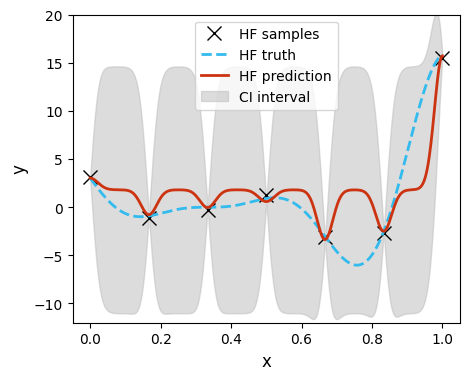

In [26]:
# for noisy case
sf_gpr_noisy = GaussianProcessRegression(design_space=func.design_space,
                                                optimizer_restart=10,
                                                noise_prior=None)
# train the gaussian process model
sf_gpr_noisy.train(X=sample_hx, Y=mf_Forrester().hf(sample_hx, noise_std=0.3))

# get the prediction
pred_y_sf_gpr_noisy, pred_std_sf_gpr_noisy = sf_gpr_noisy.predict(
    X=test_x, return_std=True)

# plot the results
font_size = 12
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    sample_x[0],
    mf_Forrester().hf(sample_hx, noise_std=0.3),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)

ax.plot(test_x, test_hy_noiseless, "--", color="#33BBEE",
        linewidth=2, label="HF truth")
ax.plot(test_x, pred_y_sf_gpr_noisy, "-", color="#CC3311",
        linewidth=2, label="HF prediction")
ax.fill_between(
    test_x.flatten(),
    (pred_y_sf_gpr_noisy - 2 * pred_std_sf_gpr_noisy).flatten(),
    (pred_y_sf_gpr_noisy + 2 * pred_std_sf_gpr_noisy).flatten(),
    edgecolor=None,
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax.set_ylabel("y", fontsize=font_size)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylim(-12, 20)
ax.legend()
plt.show()



## Have fun!